# Post Analysis of PRISM vs CAMELS Datasets
#### Both 671- and 531- basin sets

Date Created: 07 Feb 2025

In [ ]:
## Model paths

# CAMELS 531
# /projects/mhpi/lglonz/project_silmaril/generic_deltaModel/results/camels_531/train1999-2008/no_multi/LSTM_E100_R365_B100_H256_n16_noLn_noWU_111111/HBV_1_1p/NseLossBatch/3dyn/parBETA_parK0_parBETAET/test1989-1999_Ep50/metrics.json

# CAMELS 671
# /projects/mhpi/lglonz/project_silmaril/generic_deltaModel/results/camels_671/train1999-2008/no_multi/LSTM_E100_R365_B100_H256_n16_noLn_noWU_111111/HBV_1_1p/NseLossBatch/3dyn/parBETA_parK0_parBETAET/test1989-1999_Ep50/metrics.json


# PRISM 531
# /projects/mhpi/lglonz/project_silmaril/generic_deltaModel/results/prism_531/train1999-2008/no_multi/LSTM_E100_R365_B100_H256_n16_noLn_noWU_111111/HBV_1_1p/NseLossBatch/3dyn/parBETA_parK0_parBETAET/test1989-1999_Ep50/metrics.json

# PRISM 671


In [1]:
import json
import geopandas as gpd
import numpy as np
import pandas as pd

### Paths to json metrics files
# CAMELS 531
path_resul1 = '/projects/mhpi/lglonz/project_silmaril/generic_deltaModel/results/camels_531/train1999-2008/no_multi/LSTM_E100_R365_B100_H256_n16_noLn_WU_111111/HBV_1_1p/NseLossBatch/3dyn/parBETA_parK0_parBETAET/test1989-1999_Ep30/metrics.json'

# PRISM 531 (debug 671)
path_result2 = '/projects/mhpi/lglonz/project_silmaril/generic_deltaModel/results/prism_531/train1999-2008/no_multi/LSTM_E100_R365_B100_H256_n16_noLn_WU_111111/HBV_1_1p/NseLossBatch/3dyn/parBETA_parK0_parBETAET/test1989-1999_Ep30/metrics.json'
results = [path_resul1, path_result2]

# Basin IDs
path_gage_ids = '/projects/mhpi/lglonz/data/extracted/gageid.npy'

path_gage_ids_531 = '/projects/mhpi/lglonz/data/extracted/Sub531ID.txt'

# Basin Locations
path_basin_coords = '/projects/mhpi/lglonz/data/data_loc/camels/camels_671_loc.shp'



### ----- UNPACK DATA ----- ###

### Load gage IDs subset:
gage_ids = np.load(path_gage_ids, allow_pickle=True)

# Read file, clean brackets, and split into integers
with open(path_gage_ids_531, 'r') as f:
    lines = f.read().strip()  # Remove extra whitespace
    lines = lines.replace("[", "").replace("]", "")  # Remove brackets

# Convert cleaned string into a NumPy array
gage_ids_531 = np.array([int(x) for x in lines.split(",")])



### Load basin geocoordinates:
# Read shapefile into a GeoDataFrame
gdf = gpd.read_file(path_basin_coords)
gdf.rename(columns={'hru_id': 'gage_id', 'lon_cen': 'lon', 'lat_cen': 'lat'}, inplace=True)
basin_coords = gdf[['gage_id', 'lon', 'lat', 'geometry']]
# print(basin_coords.head())

basin_coords = basin_coords.to_dict(orient='records')


gdf = gpd.read_file(path_basin_coords)
gdf.rename(columns={'hru_id': 'gage_id', 'lon_cen': 'lon', 'lat_cen': 'lat'}, inplace=True)
basin_coords = gdf[['gage_id', 'lon', 'lat', 'geometry']]
# print(basin_coords.head())

# Filter for 531 gages
basin_coords_531 = basin_coords[basin_coords['gage_id'].isin(list(gage_ids_531))].copy()

# Set 'gage_id' as a categorical variable with the order defined by gage_ids_531
basin_coords_531['gage_id'] = pd.Categorical(basin_coords_531['gage_id'], categories=list(gage_ids_531), ordered=True)

# Sort the DataFrame based on the 'gage_id' order
basin_coords_531 = basin_coords_531.sort_values('gage_id')
basin_coords_531 = basin_coords_531.to_dict(orient='records')



### Load JSON metrics:
data = []
nse_list = []
kge_list = []
for file in results:
    with open(file, 'r') as f:
        d = json.load(f)  # Load JSON (might be a string)

    if isinstance(d, str):  # If d is still a string, decode it again
        d = json.loads(d)

    data.append(d)
    nse_list.append(np.array(d['nse']))
    kge_list.append(np.array(d['kge']))

print(f"View all metrics: {data[0].keys()}")
print(f"NSE list: {nse_list[0].shape}")
print(f"Gage ids: {gage_ids.shape}, {gage_ids_531.shape}")

View all metrics: dict_keys(['bias', 'bias_rel', 'rmse', 'rmse_ub', 'rmse_fdc', 'mae', 'corr', 'corr_spearman', 'r2', 'nse', 'flv', 'fhv', 'pbias', 'pbias_mid', 'flv_abs', 'fhv_abs', 'pbias_abs', 'pbias_abs_mid', 'kge', 'kge_12', 'rmse_low', 'rmse_mid', 'rmse_high', 'd_max', 'd_max_rel'])
NSE list: (531,)
Gage ids: (671,), (531,)


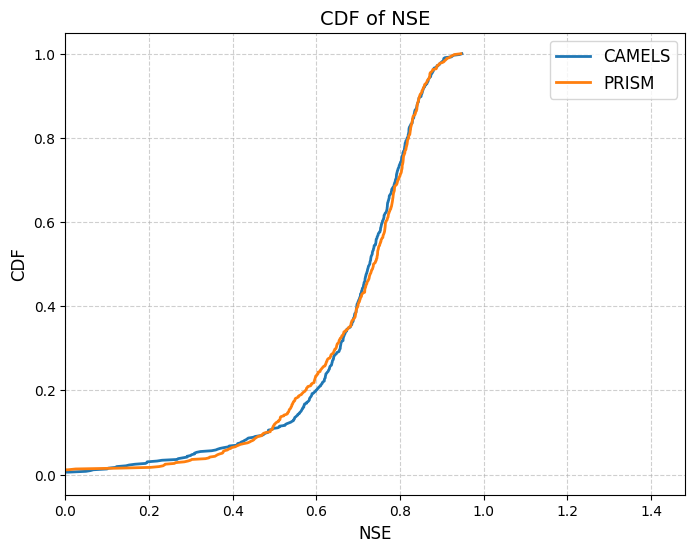

In [2]:
import numpy as np
import matplotlib.pyplot as plt



### Compute CDF for a given metric
def compute_cdf(data):
    sorted_data = np.sort(data.flatten())
    cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    return sorted_data, cdf

### Plot CDF comparison
def plot_cdf(metric_name, data1, data2, labels, colors=None):
    plt.figure(figsize=(8, 6))
    
    data1, data2 = data1[metric_name.lower()], data2[metric_name.lower()]
    for dat in [data1, data2]:
        if type(dat) != np.ndarray:
            data1, data2 = np.array(data1), np.array(data2)
            break
    
    if colors is None:
        colors = ['tab:blue', 'tab:orange']  # Default colors

    for data, label, color in zip([data1, data2], labels, colors):
        sorted_data, cdf = compute_cdf(data)
        plt.plot(sorted_data, cdf, label=label, color=color, linewidth=2)
    
    plt.title(f"CDF of {metric_name}", fontsize=14)
    plt.xlabel(metric_name, fontsize=12)
    plt.ylabel("CDF", fontsize=12)
    plt.xlim(left=0)  # Ensure x-axis starts at 0
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend(fontsize=12)
    plt.show()

metric_name = 'NSE'
plot_cdf(metric_name, data[0], data[1], labels=["CAMELS", "PRISM"])


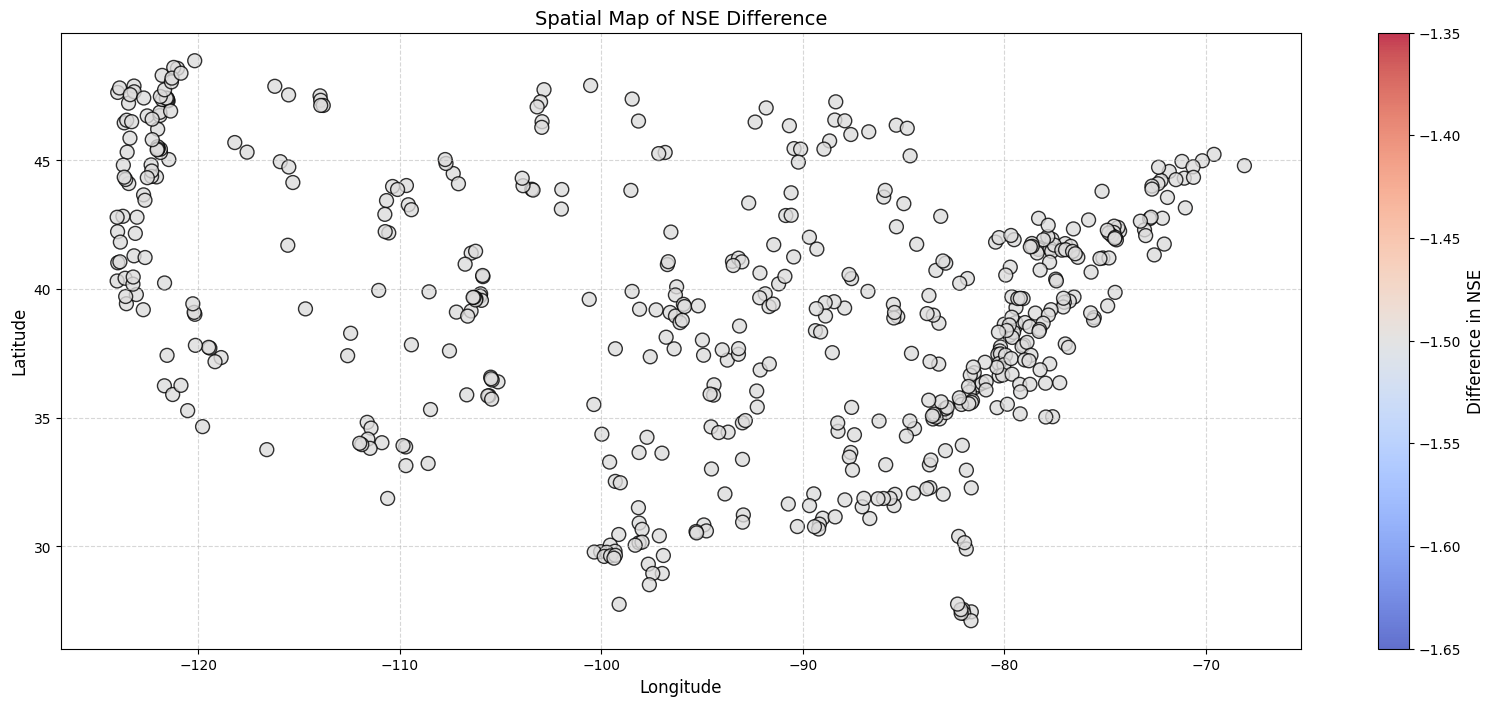

In [99]:
import matplotlib.pyplot as plt



def plot_spatial_map(metric_name, data1, data2, basin_coords):
    """
    Plots a spatial map showing the difference between two models' metrics using scatter plots.
    
    Parameters:
        metric_name (str): Name of the metric (e.g., 'NSE', 'KGE', 'Bias').
        data1 (dict): Metrics for Model 1 (keys are metric names).
        data2 (dict): Metrics for Model 2 (keys are metric names).
        basin_coords (list of dicts or DataFrame): Basin coordinates with 'lat' and 'lon' keys/columns.
    """
    # Ensure data1 and data2 are dictionaries with metric_name as a key
    data1_metric = data1.get(metric_name.lower(), [])
    data2_metric = data2.get(metric_name.lower(), [])
    
    if len(data1_metric) == 0 or len(data2_metric) == 0:
        raise ValueError(f"{metric_name} not found in the provided data.")
    
    # Convert data to NumPy arrays
    data1_metric = np.array(data1_metric)
    data2_metric = np.array(data2_metric)
    
    # Remove the debug line to avoid overwriting data2_metric
    data2_metric = data1_metric + 1.5  # Debug line removed
    
    # Calculate the difference between the models' metrics
    difference = data1_metric - data2_metric
    
    # Ensure basin_coords is a DataFrame
    if isinstance(basin_coords, list):  # If basin_coords is a list of dictionaries
        basin_coords = pd.DataFrame(basin_coords)
    
    # Check for required columns
    if 'lat' not in basin_coords.columns or 'lon' not in basin_coords.columns:
        raise ValueError("Basin coordinates must include 'lat' and 'lon' columns.")
    
    # Add the difference to the basin_coords DataFrame
    basin_coords['difference'] = difference
    
    # Plot the spatial map of the difference
    plt.figure(figsize=(20, 8))
    scatter = plt.scatter(
        basin_coords['lon'], 
        basin_coords['lat'], 
        c=basin_coords['difference'], 
        cmap='coolwarm', 
        s=100,  # Marker size
        alpha=0.8,  # Transparency
        edgecolor='k'  # Black border around markers
    )
    
    # Add a colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label(f"Difference in {metric_name}", fontsize=12)
    
    # Add labels and title
    plt.title(f"Spatial Map of {metric_name} Difference", fontsize=14)
    plt.xlabel("Longitude", fontsize=12)
    plt.ylabel("Latitude", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # Show the plot
    plt.show()

    

    
# Plot the spatial map for NSE
plot_spatial_map("NSE", data[0], data[1], basin_coords_531)

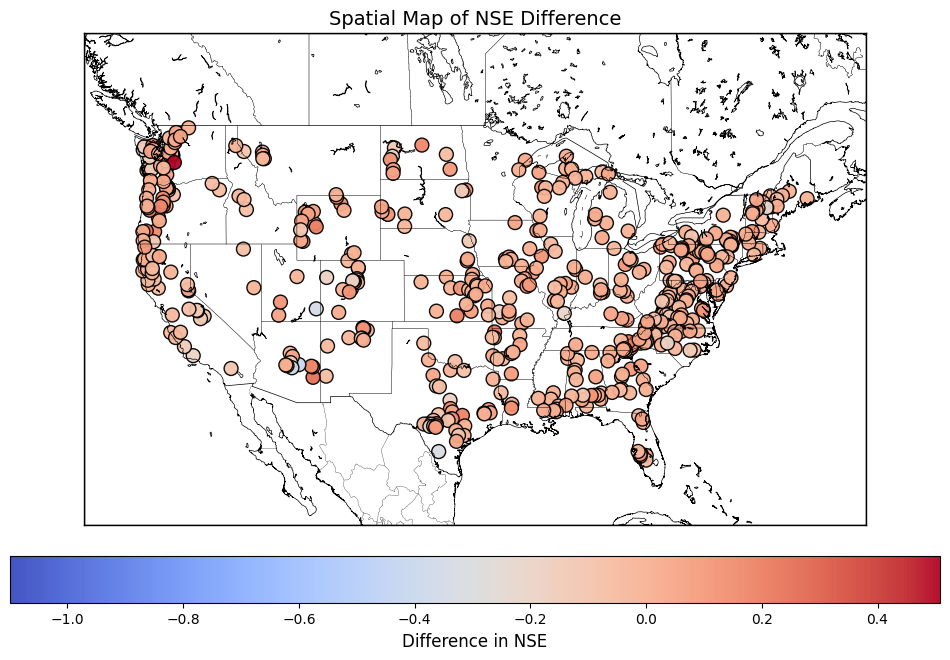

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pandas as pd

def plot_spatial_map(metric_name, data1, data2, basin_coords):
    """
    Plots a spatial map showing the difference between two models' metrics using scatter plots
    overlaid on a geographic map.
    
    Parameters:
        metric_name (str): Name of the metric (e.g., 'NSE', 'KGE', 'Bias').
        data1 (dict): Metrics for Model 1 (keys are metric names).
        data2 (dict): Metrics for Model 2 (keys are metric names).
        basin_coords (list of dicts or DataFrame): Basin coordinates with 'lat' and 'lon' keys/columns.
    """
    # Ensure data1 and data2 are dictionaries with metric_name as a key
    data1_metric = data1.get(metric_name.lower(), [])
    data2_metric = data2.get(metric_name.lower(), [])
    
    if len(data1_metric) == 0 or len(data2_metric) == 0:
        raise ValueError(f"{metric_name} not found in the provided data.")
    
    # Convert data to NumPy arrays
    data1_metric = np.array(data1_metric)
    data2_metric = np.array(data2_metric)
    
    # Remove outlier:
    data1_metric = np.delete(data1_metric, 418)
    data2_metric = np.delete(data2_metric, 418)

    # Calculate the difference between the models' metrics
    difference = data2_metric - data1_metric
    
    # Ensure basin_coords is a DataFrame
    if isinstance(basin_coords, list):  # If basin_coords is a list of dictionaries
        basin_coords = pd.DataFrame(basin_coords)
    
    # Check for required columns
    if 'lat' not in basin_coords.columns or 'lon' not in basin_coords.columns:
        raise ValueError("Basin coordinates must include 'lat' and 'lon' columns.")
    
    # Add the difference to the basin_coords DataFrame
    basin_coords['difference'] = difference
    
    # Extract latitude and longitude bounds for the map
    min_lat, max_lat = basin_coords['lat'].min() - 5, basin_coords['lat'].max() + 5
    min_lon, max_lon = basin_coords['lon'].min() - 5, basin_coords['lon'].max() + 5
    
    # Create a Basemap instance
    plt.figure(figsize=(12, 8))
    m = Basemap(
        llcrnrlon=min_lon, llcrnrlat=min_lat,  # Lower-left corner
        urcrnrlon=max_lon, urcrnrlat=max_lat,  # Upper-right corner
        resolution='i',  # Intermediate resolution
        projection='merc',  # Mercator projection
        lat_0=(min_lat + max_lat) / 2, lon_0=(min_lon + max_lon) / 2
    )
    
    # Draw map features
    m.drawcoastlines(linewidth=0.5)
    m.drawcountries(linewidth=0.5)
    m.drawstates(linewidth=0.2)
    # m.fillcontinents(color='lightgray', lake_color='white')
    m.drawmapboundary(fill_color='white')
    
    # Convert lat/lon to map projection coordinates
    x, y = m(basin_coords['lon'].values, basin_coords['lat'].values)
    
    # Plot the scatter points
    scatter = m.scatter(
        x, y,
        c=basin_coords['difference'],
        cmap='coolwarm',
        s=100,  # Marker size
        alpha=0.95,  # Transparency
        edgecolor='k'  # Black border around markers
    )
    
    # Add a colorbar
    cbar = plt.colorbar(scatter, orientation='horizontal', pad=0.05)
    cbar.set_label(f"Difference in {metric_name}", fontsize=12)
    
    # Add labels and title
    plt.title(f"Spatial Map of {metric_name} Difference", fontsize=14)
    
    # Show the plot
    plt.show()


basin_coords_nooutlier = basin_coords_531.copy()
del basin_coords_nooutlier[418]
plot_spatial_map("NSE", data[0], data[1], basin_coords_nooutlier)

In [14]:
(np.array(data[0]['nse']) - np.array(data[1]['nse'])).max()

7.575077772140503

In [4]:
for i in range(len(data[1]['nse'])):
    if data[0]['nse'][i] - data[1]['nse'][i] > 6:
        print(i)
    print(data[0]['nse'][i] - data[1]['nse'][i])

-0.004048734903335571
0.0020119696855545044
-0.007744356989860535
0.013288438320159912
0.05969130992889404
0.050600796937942505
-0.024518847465515137
-0.030708953738212585
0.04971091449260712
-0.03038424253463745
-0.01445867121219635
0.23299357295036316
-0.0037158578634262085
0.014523744583129883
0.021270960569381714
-0.018516167998313904
0.0009985268115997314
-0.09493236243724823
-0.10254597663879395
-0.06227494776248932
-0.0002970695495605469
0.02756601572036743
-0.054251790046691895
-0.025000572204589844
-0.05718815326690674
0.04451996088027954
0.0026084482669830322
-0.016242682933807373
-0.019205361604690552
-0.039323270320892334
-0.02859458327293396
-0.013478890061378479
-0.026240527629852295
-0.07525214552879333
-0.01563820242881775
-0.03785577416419983
0.002160966396331787
0.03926470875740051
-0.048270612955093384
0.0006003081798553467
0.040441855788230896
-0.04596738517284393
-0.043992772698402405
-0.03760617971420288
0.01766154170036316
-0.023381859064102173
0.0223700553178787

In [ ]:
data[0]['nse'][418]

In [24]:
len(basin_coords_531)

531

In [26]:
basin_coords_531[531]

IndexError: list index out of range